You can download the dataset from this <a href ="https://www.kaggle.com/snap/amazon-fine-food-reviews">page.</a>

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanze\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv("Reviews.csv")
data.head().style.background_gradient(cmap='YlGn')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [3]:
data.drop(data[data["Score"] == 3].index, inplace = True)

In [4]:
# Converting Numerical scores to positive or negative ratings
def partition(x):
    if x >= 3:
        return 1
    return 0

actualScores = data["Score"]
partitionedScores = actualScores.map(partition)
data["Score"] = partitionedScores
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# Let's drop duplicate rows.
data.drop_duplicates(subset = {"UserId", "ProfileName", "Time", "Text"}, keep = "first", inplace = True)

In [6]:
data = data[data["HelpfulnessNumerator"] <= data["HelpfulnessDenominator"]]

In [7]:
data.reset_index(inplace = True, drop = True)

In [8]:
data.shape

(364171, 10)

# Text Pre-processing

In [9]:
# Removing URLs
for sentence in data["Text"].values:
  sentence = re.sub(r"http\S+", "", sentence)

In [10]:
# Removing all HTML tags
for sentence in data["Text"].values:
  soup = BeautifulSoup(sentence, "html.parser")
  sentence = soup.get_text()

In [11]:
# Removing words that contain numbers
for sentence in data["Text"].values:
  sentence = re.sub("\S*\d\S*", "", sentence).strip()

# Removing special characters
for sentence in data["Text"].values:
  sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)

In [12]:
# Removing message language
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
stop = set(stopwords.words("english"))
preprocessed_reviews = []
for sentance in tqdm(data['Text'].values):
    sentance = decontracted(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:39<00:00, 9155.42it/s]


In [14]:
data["Text"] = preprocessed_reviews

In [15]:
data.duplicated().sum()

0

In [16]:
# Removing redundant features
data = data.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'],axis=1)

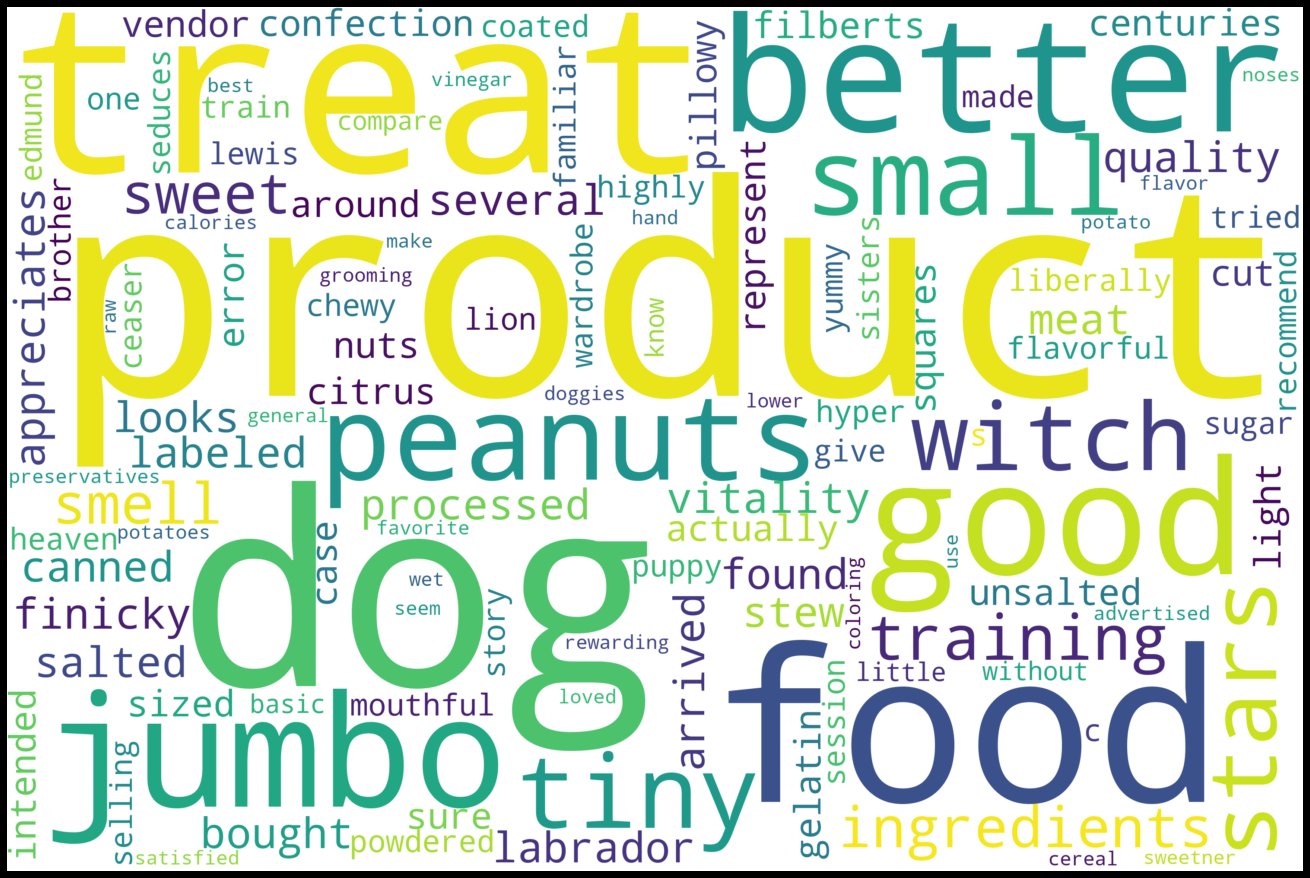

In [18]:
def wordcloud(Text):
    wordcloud = WordCloud(background_color = 'white', width = 3000, height = 2000).generate(str(Text))
    fig = plt.figure(figsize = (20, 12), facecolor = 'k', edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
wordcloud(data.Text.values)

In [19]:
x = data["Text"]
y = data["Score"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [20]:
# Build the model
model = make_pipeline(TfidfVectorizer(), BernoulliNB())
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [21]:
performance = metrics.accuracy_score(y_test, predictions)
print(performance)

0.8877325461659916


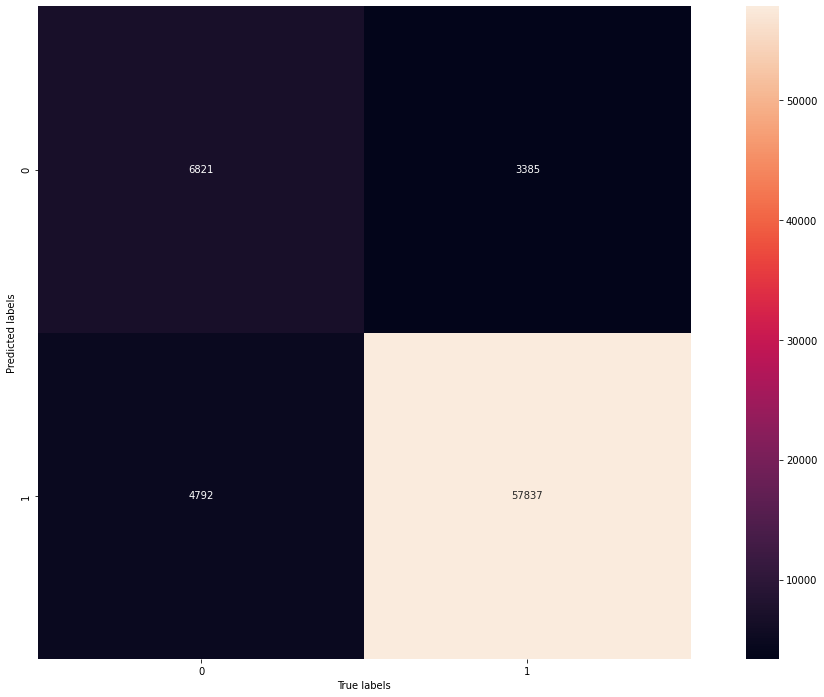

In [22]:
plt.figure(figsize = (20, 12))
mat = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()